In [1]:
import torch
import pandas as pd
import os

import Utils.Data.DataLoading as DataLoading
import Utils.EvaluationMetrics.TSNEVisual as TSNEVisual
import Utils.PTModel.Inference as Inference

import Utils.PTModel.Models as Models

import Utils.PTModel.Losses as Losses
import numpy as np
import torch.nn as nn

MODELNAME = "TestVAEwATT"

In [2]:
# Loading standard train test split
TrainingData = DataLoading.LoadTrainTestData("../data/tomData/unshuffled3x3tiles.csv", shuffle=True)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def TrainModel(dataObj, epochs, batchSize, modelClassToTrain=Models.TileEmbeddingVAE, continueTraining=None, earlyStoppingRange=0, dropLearningRate=False):
    # dataObj = {"trainData": trainingdata, "testData": testData, "weightArray": tfidfWeightArray}

    if continueTraining == None:
        model = modelClassToTrain()
    else:
        model = continueTraining
        
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    imageCritierion = nn.MSELoss()
    textCritierion = Losses.WeightedBCE(dataObj["weightArray"].to(device))

    imageLossWeight = 0.8
    textLossWeight = 1.0 - imageLossWeight

    model.to(device)
    model.train()

    trainData = dataObj["trainData"]
    losses = []
    batchLosses = []
    valTextLosses = []

    for i in range(epochs):

        losses.append([])

        for j in range(0, trainData.shape[0], batchSize):

            xImages = np.array(trainData.iloc[j:j+batchSize]["image"].tolist())
            yImages = xImages[:, 16:32, 16:32, :]
            # print(xImages.shape)
            # print(yImages.shape)

            xImageBatch = torch.tensor(xImages, dtype=torch.float32)
            xImageBatch = xImageBatch.reshape((-1, 3, 48, 48))
            xImageBatch = xImageBatch.to(device)

            yImageBatch = torch.tensor(yImages, dtype=torch.float32)
            yImageBatch = yImageBatch.reshape((-1, 3, 16, 16))
            yImageBatch = yImageBatch.to(device)
            
            xTextbatch = torch.tensor(trainData.iloc[j:j+batchSize]["encodedAffordances"].tolist(), dtype=torch.float32).to(device)

            yPredImages, yPredTexts = model(xImageBatch, xTextbatch)
            # print(yPredImages.shape)
            # print(yImageBatch.shape)

            imageLoss = imageCritierion(yPredImages, yImageBatch)
            textLoss = textCritierion(yPredTexts, xTextbatch)
            # print(imageLoss)
            # print(textLoss)

            loss = torch.add(torch.mul(imageLoss, imageLossWeight), torch.mul(textLoss, textLossWeight))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses[i].append(loss.cpu().detach().item())

        batchLosses.append(sum(losses[i])/len(losses[i]))

        valTrueData = torch.tensor(dataObj["testData"]["encodedAffordances"].to_list(), dtype=torch.float32).to(device)
        valPredData = torch.tensor(Inference.ModelInference(model, dataObj["testData"], clampTextOutput=False)[1], dtype=torch.float32).to(device)
        valTextLoss = textCritierion(valPredData, valTrueData)

        valTextLosses.append(valTextLoss)

        print(f"Epoch {i}: loss {batchLosses[i]} | Val Text Loss: {valTextLoss}")

        if earlyStoppingRange > 0 and i > earlyStoppingRange - 1:
            # print("In Early Stopping check")
            # print(batchLosses[-earlyStoppingRange:])
            # print(sum(batchLosses[-earlyStoppingRange:]) / earlyStoppingRange)
            # print(batchLosses[(-earlyStoppingRange)-1])
            if valTextLosses[-1] > valTextLosses[(-earlyStoppingRange)-1]:
                print("Early Stopping...")
                return model
        
        if dropLearningRate and i > 5 - 1:

            if sum(valTextLosses[-5:]) / 5 > valTextLosses[(-5)-1]:
                print("Dropping Learning Rate...")
                for g in optimizer.param_groups:
                    g['lr'] /= 10
                
                dropLearningRate = False
                    
    
    return model

In [13]:
#model = Training.TrainModel(TrainingData, 1, 32, Models.TileEmbeddingVAE)
model = TrainModel(TrainingData, 50, 32, Models.TileEmbeddingVAEwMHA, dropLearningRate=True, earlyStoppingRange=2)

Epoch 0: loss 7133.058123248085 | Val Text Loss: 256.95928955078125
Epoch 1: loss 3829.8481653460813 | Val Text Loss: 101.5806655883789
Epoch 2: loss 2558.8404200606406 | Val Text Loss: 60.76700210571289
Epoch 3: loss 1729.311317457399 | Val Text Loss: 41.26639175415039
Epoch 4: loss 1166.605097226944 | Val Text Loss: 28.18254852294922
Epoch 5: loss 785.6376615426045 | Val Text Loss: 20.54151725769043
Epoch 6: loss 518.4443258011108 | Val Text Loss: 16.351634979248047
Epoch 7: loss 331.99636149702866 | Val Text Loss: 11.290251731872559
Epoch 8: loss 204.97490772091473 | Val Text Loss: 8.86589527130127
Epoch 9: loss 129.79896712091423 | Val Text Loss: 7.0622782707214355
Epoch 10: loss 79.41459786193197 | Val Text Loss: 5.926193714141846
Epoch 11: loss 64.83426725038626 | Val Text Loss: 5.661205291748047
Epoch 12: loss 44.83718071780027 | Val Text Loss: 4.211176872253418
Epoch 13: loss 33.919134574080445 | Val Text Loss: 3.7076797485351562
Epoch 14: loss 29.325559407525546 | Val Text Los

In [14]:
if os.path.isdir(f"Models/{MODELNAME}"):
    raise RuntimeError(f"Folder for model {MODELNAME} already exists. Delete the folder and retry or change the model name.")

os.mkdir(f"Models/{MODELNAME}")
torch.save(model, f"Models//{MODELNAME}/{MODELNAME}.pt")

In [15]:
Inference.SaveUnifiedRepresentation(model, pd.concat([TrainingData["trainData"], TrainingData["testData"]]), MODELNAME)

In [16]:
data, fitEmbeddings = TSNEVisual.TrainTSNEModel(MODELNAME)

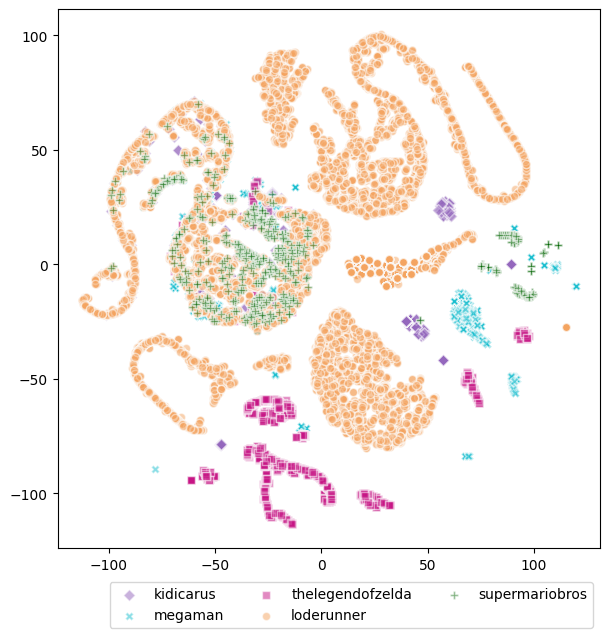

In [17]:
TSNEVisual.DisplayTSNEEmbeddings(data, fitEmbeddings, modelName=MODELNAME, save=True)